<a href="https://colab.research.google.com/github/jude-don/CodePath-Prework/blob/main/Trendlytics_Security_Analyzer_Code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data Engineering

Install Python Libraries (Google Trends, AWS RDS Driver and Time conversion driver)



In [ ]:
!pip install pytrends
!pip install pymysql
!pip install pytz

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 785.7 kB/s eta 0:00:00


Import Python Libraries

In [ ]:
from os import name
import requests
import re
import json
import time
import pymysql
import csv
import pandas as pd
import threading
import pytz
import re
from dataclasses import dataclass
from typing import List
from typing import Any
from collections import namedtuple
from typing import List
from pytrends.request import TrendReq
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import urllib.parse
import seaborn as sns

Data class models to define the type of list to hold trending words, google and bing search links, time of discovery and virus total results .

In [ ]:
@dataclass
class SearchLinkData:
  search_link: str # search link
  datetime_of_discovery: str # the time the link was discovered

@dataclass
class SearchResult:
  search_item: str # Search item
  search_results: List[SearchLinkData] # List of search results

@dataclass
class TrendAnalysis:
  trend: str # Search item
  search_link: str # Google search link
  datetime_of_discovery : str
  virus_total_result: str # Virus Total scan url result

Functions to acquire Twitter and Google Trends

In [ ]:
# Twitter Trends Retrieval

def fetch_twitter_trends():
    url = "https://twitter-trends5.p.rapidapi.com/twitter/request.php"
    payload = {"woeid": ""} # Enter woeid from virus total
    headers = {
        "content-type": "application/x-www-form-urlencoded",
        "X-RapidAPI-Key": "", # Enter rapid api key
        "X-RapidAPI-Host": "twitter-trends5.p.rapidapi.com",
    }
    response = requests.post(url, data=payload, headers=headers)
    response_json = response.json()

    # Ensure `trends` key exists and is a dictionary
    if "trends" in response_json and isinstance(response_json["trends"], dict):
        trends_list = list(response_json["trends"].values())  # Convert to list
        return trends_list
    else:
        raise ValueError("Unexpected Twitter API response format.")



# Google Trends Retrieval
def fetch_google_trends():
    from pytrends.request import TrendReq
    pytrends = TrendReq(hl='en-US', tz=300)
    trends = pytrends.trending_searches(pn='united_states')
    sorted_trends = sorted(trends[0][:20])
    return sorted_trends



# Trend Sorting and Refining
def refine_trends(trends):
    trend_names = sorted(set(trend.get('name') for trend in trends))
    return trend_names[:20] if len(trend_names) >= 20 else trend_names

def refine_trends(trends_list):
    if not isinstance(trends_list, list):
        raise ValueError("Expected trends_list to be a list.")

    name_of_trends_list = []

    for trend in trends_list:
        # Handle trend types from different sources
        if isinstance(trend, dict) and "name" in trend:
            name_of_trends_list.append(trend["name"])  # Twitter trends
        elif isinstance(trend, str):
            name_of_trends_list.append(trend)  # Google trends
        else:
            print(f"Unexpected trend format: {trend}")

    # Remove duplicates, sort, and limit to 20 items
    refined_trends = sorted(set(name_of_trends_list))
    return refined_trends[:20] if len(refined_trends) > 20 else refined_trends



Google Search Engine API calls

In [ ]:
# Google API Payload Builder
def build_google_payload(query, start=0, results_count=10, date_range='w1'):
    return {
        'key': '',# Enter google search engine key
        'q': query,
        'cx': '',# Enter google search engine cx
        'start': start,
        'num': results_count,
        'dateRestrict': date_range
    }

# Google API Request
def execute_google_request(payload):
    api_url = 'https://www.googleapis.com/customsearch/v1'
    response = requests.get(api_url, params=payload)
    response.raise_for_status()
    return response.json()


Bing Search Engine Api Functions

In [ ]:
# Bing Search Payload
def create_bing_payload(query):
    excluded_sites = [
        "facebook.com", "x.com", "tiktok.com", "cnn.com",
        "theinsider.com", "twitch.tv", "soundcloud.com", "vogue.com",
        "wikipedia.org", "yahoo.com", "amazon.com", "netflix.com",
        "msn.com", "youtube.com", "linkedin.com", "telegram.me", "reddit.com"
    ]
    exclusion = " ".join(f"-site:{site}" for site in excluded_sites)
    return {
        'q': f"{query} {exclusion}",
        'count': '10',
        'freshness': 'Week',
        'mkt': 'en-US',
        'safeSearch': 'Off'
    }


# Bing API Request
def execute_bing_request(payload, api_key="aa342d3c4f8e4efa948b5c72b2e833c1"):
    api_url = "https://api.bing.microsoft.com/v7.0/search"
    headers = {"Ocp-Apim-Subscription-Key": api_key}
    response = requests.get(api_url, headers=headers, params=payload)
    response.raise_for_status()
    return response.json()

Virus Total API Functions

In [ ]:
# Constants for VirusTotal
API_KEY = "" # Enter virus total

# Function to scan a URL with VirusTotal
def scan_url_with_virustotal(url_to_scan):
    """
    Submits a URL to VirusTotal for scanning.

    Parameters:
    url_to_scan (str): The URL to be scanned.

    Returns:
    str: The analysis URL for further investigation.
    """
    api_url = "https://www.virustotal.com/api/v3/urls"
    payload = {"url": url_to_scan}
    headers = {
        "accept": "application/json",
        "x-apikey": API_KEY,
        "content-type": "application/x-www-form-urlencoded"
    }

    response = requests.post(api_url, data=payload, headers=headers)

    if response.status_code == 200:
        analysis_url = response.json()["data"]["links"]["self"]
        print(f"Scan submitted successfully. Analysis URL: {analysis_url}")
        return analysis_url
    else:
        print(f"Error submitting scan: {response.status_code}, {response.text}")
        raise Exception(response.text)

# Function to analyze a URL with VirusTotal
def analyze_url_with_virustotal(analysis_url, retries=3):
    """
    Retrieves the analysis results of a previously submitted URL.

    Parameters:
    analysis_url (str): The analysis URL retrieved from the scan step.
    retries (int): Number of attempts to retrieve results in case of delays.

    Returns:
    str: The analysis result ("Malicious", "Suspicious", "Clean", or an error message).
    """
    headers = {
        "accept": "application/json",
        "x-apikey": API_KEY
    }

    for attempt in range(retries):
        response = requests.get(analysis_url, headers=headers)

        if response.status_code == 200:
            response_json = response.json()
            stats = response_json.get("data", {}).get("attributes", {}).get("stats", {})

            malicious = stats.get("malicious", 0)
            suspicious = stats.get("suspicious", 0)
            harmless = stats.get("harmless", 0)

            if malicious > 0:
                return "Malicious"
            elif suspicious > 0:
                return "Suspicious"
            elif harmless > 0:
                return "Clean"
            else:
                return "No significant data"

        print(f"Retrying... Attempt {attempt + 1}/{retries}")
        time.sleep(5)

    print(f"Failed to retrieve analysis for URL: {analysis_url}")
    return "Analysis failed"


AWS RDS Queries and Connections

In [ ]:
import pymysql
import csv

# Database connection details
DB_HOST = '' # Enter database host address
DB_PORT = # Enter database port number
DB_USER = '' # Enter database username
DB_PASSWORD = '' # Enter database password
DB_NAME = '' # Enter database name

# Function to connect to the database
def create_db_connection():
    """
    Establishes a connection to the database.
    Returns:
        pymysql.connections.Connection: A connection object.
    """
    try:
        connection = pymysql.connect(
            host=DB_HOST,
            port=DB_PORT,
            user=DB_USER,
            password=DB_PASSWORD,
            database=DB_NAME
        )
        print("Database connection established successfully.")
        return connection
    except Exception as e:
        print(f"Failed to connect to database: {e}")
        raise

# Function to retrieve all data from a database table
def retrieve_all_data(connection):
    """
    Fetches all rows from the TrendData table.

    Parameters:
        connection: Database connection object.
    """
    try:
        with connection.cursor() as cursor:
            query = "SELECT * FROM TrendData"
            cursor.execute(query)
            results = cursor.fetchall()
            for row in results:
                print(row)
    except Exception as e:
        print(f"Error retrieving data: {e}")

# Function to insert trend data into the database
def push_data_to_db(connection, trend_data):
    """
    Inserts trend data into the TrendData table.

    Parameters:
        connection: Database connection object.
        trend_data (list of tuples): Each tuple contains (TrendName, TrendLink, VirusTotalResult, DiscoveryTime).
    """
    try:
        with connection.cursor() as cursor:
            query = """
            INSERT INTO TrendData (TrendName, TrendLink, VirusTotalResult, DiscoveryTime)
            VALUES (%s, %s, %s, %s);
            """
            cursor.executemany(query, trend_data)
            connection.commit()
            print("Data inserted successfully.")
    except Exception as e:
        print(f"Error inserting data: {e}")
        connection.rollback()

# Function to export data from the database to a CSV file
def export_to_csv(connection, table_name='TrendData', file_name='data.csv'):
    """
    Exports data from a specified database table to a CSV file.

    Parameters:
        connection: Database connection object.
        table_name (str): Name of the table to export data from.
        file_name (str): Name of the CSV file to create.
    """
    try:
        with connection.cursor() as cursor:
            query = f"SELECT * FROM {table_name}"
            cursor.execute(query)
            results = cursor.fetchall()

            headers = [desc[0] for desc in cursor.description]

            with open(file_name, 'w', newline='', encoding='utf-8') as csv_file:
                writer = csv.writer(csv_file)
                writer.writerow(headers)  # Write column headers
                writer.writerows(results)  # Write data rows

            print(f"Data exported to {file_name} successfully.")
    except Exception as e:
        print(f"Error exporting data to CSV: {e}")
    cursor.close()


Main Data Utility Functions

In [ ]:
# Function to extract time expressions from text
def extract_time_from_text(text):
    """
    Extracts a time expression (e.g., '3 days ago' or '12 hours ago') from text
    and calculates the corresponding date and time.

    Parameters:
        text (str): A string containing a time expression.

    Returns:
        str: A formatted date-time string ('YYYY-MM-DD HH:MM:SS'), or a message if not found.
    """
    time_pattern = re.compile(r'(\d+)\s+(hours|days)\s+ago')
    match = time_pattern.search(text)

    if not match:
        return "No valid time expression found."

    # Extract the number and the unit (hours or days)
    number = int(match.group(1))
    unit = match.group(2)

    # Convert to hours if unit is days
    if unit == "days":
        number *= 24

    # Calculate the past date-time
    past_datetime = datetime.now() - timedelta(hours=number)

    return past_datetime.strftime('%Y-%m-%d %H:%M:%S')


# Function to calculate date-time for a specific number of hours ago
def find_date_hours_ago(hours_ago):
    """
    Calculates the date and time for a given number of hours ago.

    Parameters:
        hours_ago (int): Number of hours ago.

    Returns:
        str: A formatted date-time string ('YYYY-MM-DD HH:MM:SS').
    """
    past_datetime = datetime.now() - timedelta(hours=hours_ago)
    return past_datetime.strftime('%Y-%m-%d %H:%M:%S')


# Function to convert ISO 8601 date strings to a custom format
def convert_to_custom_format(iso_date_str):
    """
    Converts an ISO 8601 date string to a custom date-time format.

    Parameters:
        iso_date_str (str): ISO 8601 date string (e.g., '2024-12-15T10:30:00.123456').

    Returns:
        str: The custom-formatted date-time ('YYYY-MM-DD HH:MM:SS').
    """
    try:
        # Truncate fractional seconds if present
        if '.' in iso_date_str:
            iso_date_str = iso_date_str.split('.')[0]

        # Parse ISO 8601 string
        date_obj = datetime.fromisoformat(iso_date_str)

        # Return formatted date
        return date_obj.strftime('%Y-%m-%d %H:%M:%S')
    except Exception as e:
        return f"Error parsing date: {e}"


Main Functions

In [ ]:
# Function to search trends using Google
def fetch_google_search_results(search_items):
    """
    Fetches search results from Google for a list of search items.

    Parameters:
        search_items (list): List of search queries.

    Returns:
        list: List of SearchResult instances containing search data.
    """
    search_results = []
    for query in search_items:
        print(f"Processing search item: {query}")
        try:
            payload = build_google_payload(query)
            response = execute_google_request(payload)

            if 'items' in response:
                items = []
                for result in response['items']:
                    date_time = extract_time_from_text(result.get('snippet', ''))
                    search_link = result.get('link', '')
                    search_link_data = SearchLinkData(search_link, date_time)
                    items.append(search_link_data)

                search_results.append(SearchResult(search_item=query, search_results=items))
            else:
                print(f"No results found for query: {query}")
        except Exception as e:
            print(f"Error fetching results for {query}: {e}")
    print("Google search results retrieval complete.\n")
    return search_results



# Function to search trends using Bing
def fetch_bing_search_results(search_items):
    """
    Fetches search results from Bing for a list of search items.

    Parameters:
        search_items (list): List of search queries.

    Returns:
        list: List of SearchResult instances containing search data.
    """
    search_results = []
    for query in search_items:
        print(f"Processing search item: {query}")
        try:
            payload = create_bing_payload(query)
            response = execute_bing_request(payload)

            if 'webPages' in response and response['webPages']['value']:
                items = []
                for result in response['webPages']['value']:
                    date_published = result.get('datePublished', None)
                    date_time = (
                        convert_to_custom_format(date_published)
                        if date_published else "Unknown"
                    )
                    search_link = result.get('url', '')
                    search_link_data = SearchLinkData(search_link, date_time)
                    items.append(search_link_data)

                search_results.append(SearchResult(search_item=query, search_results=items))
            else:
                print(f"No results found for query: {query}")
        except Exception as e:
            print(f"Error fetching results for {query}: {e}")
    print("Bing search results retrieval complete.\n")
    return search_results



# Function to search for malware using VirusTotal
def analyze_search_results_for_malware(search_results):
    """
    Analyzes search results for malware using VirusTotal.

    Parameters:
        search_results (list): List of SearchResult instances.

    Returns:
        list: List of TrendAnalysis instances containing analysis data.
    """
    malware_analysis_results = []
    print("Starting malware analysis...\n")

    for search_result in search_results:
        # Ensure `search_result` is a valid SearchResult instance
        if not isinstance(search_result, SearchResult):
            print(f"Invalid search_result object: {search_result}")
            continue

        print(f"Analyzing search item: {search_result.search_item}")

        for search_link_data in search_result.search_results:
            # Validate `search_link_data` is a valid SearchLinkData instance
            if not isinstance(search_link_data, SearchLinkData):
                print(f"Invalid search_link_data object: {search_link_data}")
                continue

            try:
                # Step 1: Scan the URL using VirusTotal
                analysis_url = scan_url_with_virustotal(search_link_data.search_link)

                # Step 2: Wait and analyze the results
                time.sleep(20)  # Give VirusTotal time to process
                scan_result = analyze_url_with_virustotal(analysis_url)

                # Step 3: Create and store the TrendAnalysis object
                trend_analysis = TrendAnalysis(
                    trend=search_result.search_item,
                    search_link=search_link_data.search_link,
                    datetime_of_discovery=search_link_data.datetime_of_discovery,
                    virus_total_result=scan_result
                )
                malware_analysis_results.append(trend_analysis)
                print(f"Processed: {search_link_data.search_link}, Result: {scan_result}")

            except Exception as e:
                print(f"Error analyzing {search_link_data.search_link}: {e}")

            # Pause between requests to avoid hitting API rate limits
            time.sleep(5)

    print("Malware analysis complete.\n")
    return malware_analysis_results







# Function to analyze Twitter trends
def analyze_twitter_trends():
    """
    Fetches Twitter trends, analyzes search results, and stores data in the database.
    """
    print("Fetching Twitter trends...")
    twitter_trends = fetch_twitter_trends()
    refined_trends = refine_trends(twitter_trends)

    print("Fetching search results for Twitter trends...")
    google_results = fetch_google_search_results(refined_trends)
    bing_results = fetch_bing_search_results(refined_trends)

    all_search_results = google_results + bing_results

    print("Analyzing search results for malware...")
    malware_analysis_results = analyze_search_results_for_malware(all_search_results)

    print("Storing analysis results in the database...")
    connection = create_db_connection()
    push_data_to_db(connection, malware_analysis_results)
    connection.close()
    print("Twitter trends analysis complete.")




# Function to analyze Google trends
def analyze_google_trends():
    """
    Fetches Google trends, analyzes search results, and stores data in the database.
    """
    print("Fetching Google trends...")
    google_trends = fetch_google_trends()

    print("Fetching search results for Google trends...")
    google_results = fetch_google_search_results(google_trends)
    bing_results = fetch_bing_search_results(google_trends)

    all_search_results = google_results + bing_results

    print("Analyzing search results for malware...")
    malware_analysis_results = analyze_search_results_for_malware(all_search_results)

    print("Storing analysis results in the database...")
    connection = create_db_connection()
    push_data_to_db(connection, malware_analysis_results)
    connection.close()
    print("Google trends analysis complete.")

Main Script (Run cells above sequentially and this cell for Results)

In [ ]:
if __name__ == '__main__':
    try:
        print("Step 1: Fetching Twitter trends...")
        twitter_trends = fetch_twitter_trends()  # Get Twitter trends

        print("Step 2: Fetching Google trends...")
        google_trends = fetch_google_trends()  # Get Google trends

        print("Step 3: Refining trends...")
        combined_trends = refine_trends(twitter_trends + google_trends)  # Combine and refine trends

        print("Step 4: Fetching Google search results...")
        google_search_results = fetch_google_search_results(combined_trends)  # Google search

        print("Step 5: Fetching Bing search results...")
        bing_search_results = fetch_bing_search_results(combined_trends)  # Bing search

        print("Step 6: Combining search results...")
        all_search_results = google_search_results + bing_search_results  # Combine all search results

        print("Step 7: Analyzing search results for malware...")
        malware_analysis_results = analyze_search_results_for_malware(all_search_results)  # Malware analysis

        print("Step 8: Connecting to the database...")
        db_connection = create_db_connection()  # Connect to the database

        print("Step 9: Storing results in the database...")
        push_data_to_db(db_connection, malware_analysis_results)  # Store results

        print("Process complete. All trends and analysis results have been processed and saved.")

    except Exception as e:
        print(f"An error occurred during execution: {e}")

    finally:
        # Ensure the database connection is closed
        try:
            db_connection.close()
            print("Database connection closed.")
        except NameError:
            print("No active database connection to close.")




# DATA ANALYSIS

Get the Stored Data from the Database to a csv file.

In [ ]:
db_connection = create_db_connection()
export_to_csv(db_connection)
db_connection.close()

Read in Stored Data

In [ ]:
#with open('trendresults.csv', 'r') as csv_file:
data = pd.read_csv('data.csv')
data.tail()


,TrendName,TrendLink,VirusTotalResult,DiscoveryTime
9559,Warriors,https://hoopshype.com/2023/11/28/warriors-vs-k...,Clean site,2023-11-29 03:00:00
9560,Warriors,https://www.cbssports.com/nba/news/warriors-vs...,Clean site,2023-11-28 12:38:00
9561,Warriors,https://bluemanhoop.com/golden-state-warriors-...,Clean site,2023-11-25 00:00:00
9562,Warriors,https://www.eastbaytimes.com/sports/nba/golden...,Clean site,2023-11-21 00:00:00
9563,Warriors,https://www.nba.com/warriors/videos,Clean site,2023-11-26 00:00:00


Data Refinement and Manipulation

In [ ]:
data.shape

(9564, 4)

In [ ]:
data.drop_duplicates()
data.shape

(9564, 4)

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9564 entries, 0 to 9563
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   TrendName         9564 non-null   object
 1   TrendLink         9564 non-null   object
 2   VirusTotalResult  9563 non-null   object
 3   DiscoveryTime     7194 non-null   object
dtypes: object(4)
memory usage: 299.0+ KB


In [ ]:
# Convert DiscoveryTime to datetime and filter out invalid timestamps
data['DiscoveryTime'] = pd.to_datetime(data['DiscoveryTime'], errors='coerce')
data_with_time = data.dropna(subset=['DiscoveryTime'])

In [ ]:
data_with_time.shape

(6711, 4)

Frequency Analysis of Malicious Sites

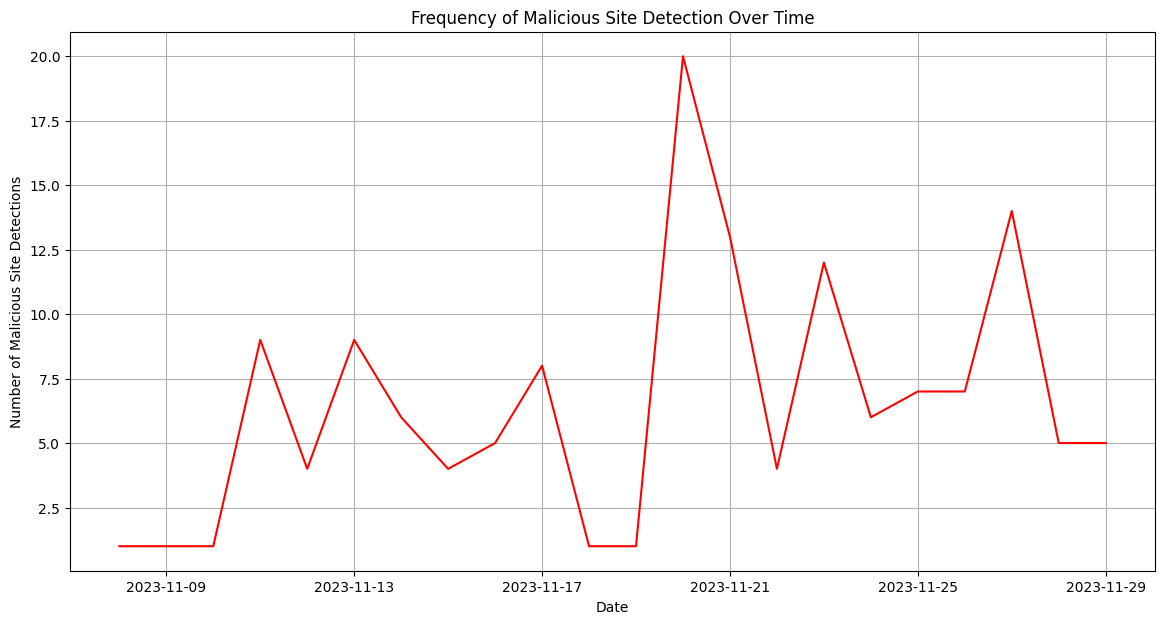

<ipython-input-18-23e8c9daa506>:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_with_time['MaliciousIndicator'] = (data_with_time['VirusTotalResult'] == 'Malicious site').astype(int)
<ipython-input-18-23e8c9daa506>:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_with_time['Domain'], data_with_time['Path'] = zip(*data_with_time['TrendLink'].map(extract_url_parts))
<ipython-input-18-23e8c9daa506>:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try 

(www.sotwe.com               68
 t.co                        14
 www.wsj.com                  9
 www.givingtuesday.org        4
 awfulannouncing.com          3
 www.cbtnuggets.com           2
 www.r1s1sports.com           2
 www.max.com                  2
 www.tvseasonspoilers.com     2
 www.marwar.com               2
 Name: Domain, dtype: int64,
 hashtag                                       25
                                               10
 search                                         7
 2023                                           5
 articles                                       5
 news                                           4
 new                                            2
 finance                                        2
 moments-that-popped-kansas-99-manhattan-61     2
 Izyvybez                                       2
 Name: PathStart, dtype: int64)

In [ ]:
# Frequency Analysis
# Filter out the data for malicious sites
malicious_sites_data = data[data['VirusTotalResult'] == 'Malicious site']

# Count the occurrence of each trend name associated with malicious sites
malicious_trends_count = malicious_sites_data['TrendName'].value_counts().reset_index()
malicious_trends_count.columns = ['TrendName', 'MaliciousCount']

# Display the count of malicious trends
malicious_trends_count.head()

# Trend Over Time
# Filter for malicious sites for the temporal analysis
malicious_sites_time_data = data_with_time[data_with_time['VirusTotalResult'] == 'Malicious site']

# Group by DiscoveryTime by date and count occurrences of malicious sites
malicious_sites_over_time = malicious_sites_time_data.groupby(malicious_sites_time_data['DiscoveryTime'].dt.date).size()

# Plotting the frequency of malicious site detections over time
plt.figure(figsize=(14, 7))
malicious_sites_over_time.plot(kind='line', color='red')
plt.title('Frequency of Malicious Site Detection Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Malicious Site Detections')
plt.grid(True)
plt.show()

# Correlation Analysis
# Convert VirusTotalResult to a binary indicator: 1 for Malicious site, 0 for Clean site
data_with_time['MaliciousIndicator'] = (data_with_time['VirusTotalResult'] == 'Malicious site').astype(int)

# Count the total occurrences of each trend name
total_trends_count = data_with_time['TrendName'].value_counts().reset_index()
total_trends_count.columns = ['TrendName', 'TotalCount']

# Merge the malicious count with the total count for each trend name
trend_correlation_data = pd.merge(malicious_trends_count, total_trends_count, on='TrendName')

# Calculate the proportion of malicious occurrences for each trend name
trend_correlation_data['MaliciousProportion'] = trend_correlation_data['MaliciousCount'] / trend_correlation_data['TotalCount']

# Perform a correlation analysis between TotalCount and MaliciousProportion
correlation_result = trend_correlation_data[['TotalCount', 'MaliciousProportion']].corr()

# Display the correlation results
correlation_result

# Link Analysis
# Function to extract domain and path from URL
def extract_url_parts(url):
    try:
        parsed_url = urllib.parse.urlparse(url)
        domain = parsed_url.netloc
        path = parsed_url.path
        return domain, path
    except Exception as e:
        return "error", "error"

# Apply the function to the TrendLink column for the entire dataset
data_with_time['Domain'], data_with_time['Path'] = zip(*data_with_time['TrendLink'].map(extract_url_parts))

# Focus on the malicious URLs
malicious_urls = data_with_time[data_with_time['MaliciousIndicator'] == 1]

# Most common domains and path beginnings for malicious URLs
common_domains_malicious = malicious_urls['Domain'].value_counts().head(10)
malicious_urls['PathStart'] = malicious_urls['Path'].apply(lambda x: x.split('/')[1] if len(x.split('/')) > 1 else x)
common_paths_malicious = malicious_urls['PathStart'].value_counts().head(10)

# Display the most common domains and path starts
common_domains_malicious, common_paths_malicious

In [ ]:
correlation_result

,TotalCount,MaliciousProportion
TotalCount,1.00000,-0.41236
MaliciousProportion,-0.41236,1.00000


**Possible Insights**

1. Frequency of Malicious Trends: Malicious sites are more frequently associated with certain trending terms such us #justprayforme and #NickiMail, suggesting that malicious actors target popular terms often for greater impact

2. Trend Over Time: The number of malicious site detections fluctuates over time, indicating that malicious activity is not constant and may correlate with external factors such as current events, popularity of trends, or eveolving tactics of malicious actors

3. Negative correlation: There is a negative correlation between the frequency of a trend and its association with malicious sites. This means that popular trends do not necessarily have a higher proportion of malicious links and represent a smaller proportion of the overall mentions of that trend

4. Common Domains and Paths: The analysis revealed that certain domains and URL paths are more commonly associated with malicious sites. For example, Twitter's URL shortener (t.co) and www.sotwe.com were among common domains. This suggests that attackers may use certain platforms or disguise their links using URL shorteners to hide the malicious destination

5. Patterns in Malicious URLs: The analysis of URL structures showed that paths beginning with /hashtag and other specific patterns are commonly found in malicious URLs. This could indicate a strategy of mimicking social media navigation to trick users.

Malicious Trend Count

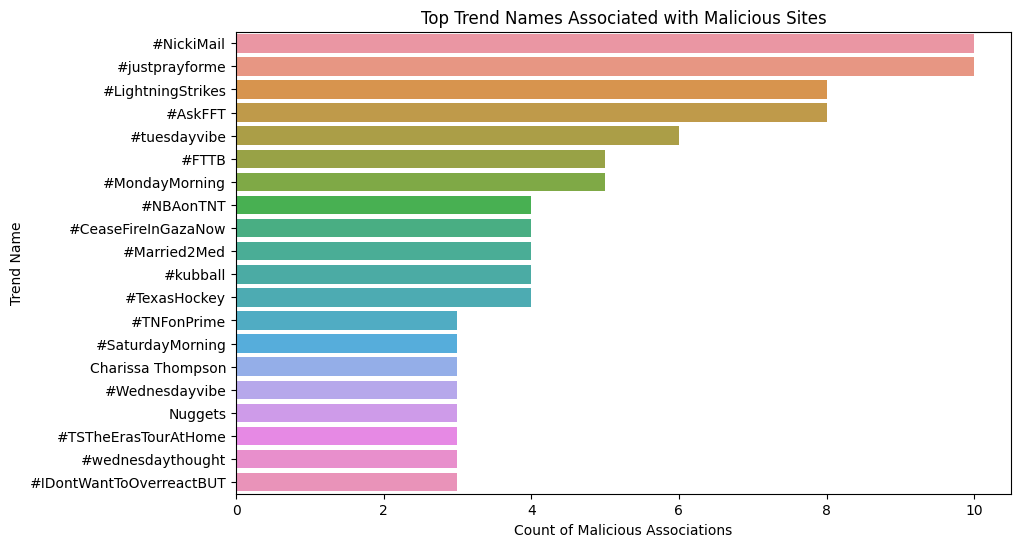

In [ ]:
# Assuming malicious_trends_count is the DataFrame with trend names and their counts
top_trends = malicious_trends_count.head(20)
plt.figure(figsize=(10, 6))
sns.barplot(x='MaliciousCount', y='TrendName', data=top_trends)
plt.title('Top Trend Names Associated with Malicious Sites')
plt.xlabel('Count of Malicious Associations')
plt.ylabel('Trend Name')
plt.show()

Heatmap of Top Trend Names and Days of the Week

<ipython-input-22-d3cb3af5c9ad>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_with_time['DayOfWeek'] = data_with_time['DiscoveryTime'].dt.day_name()


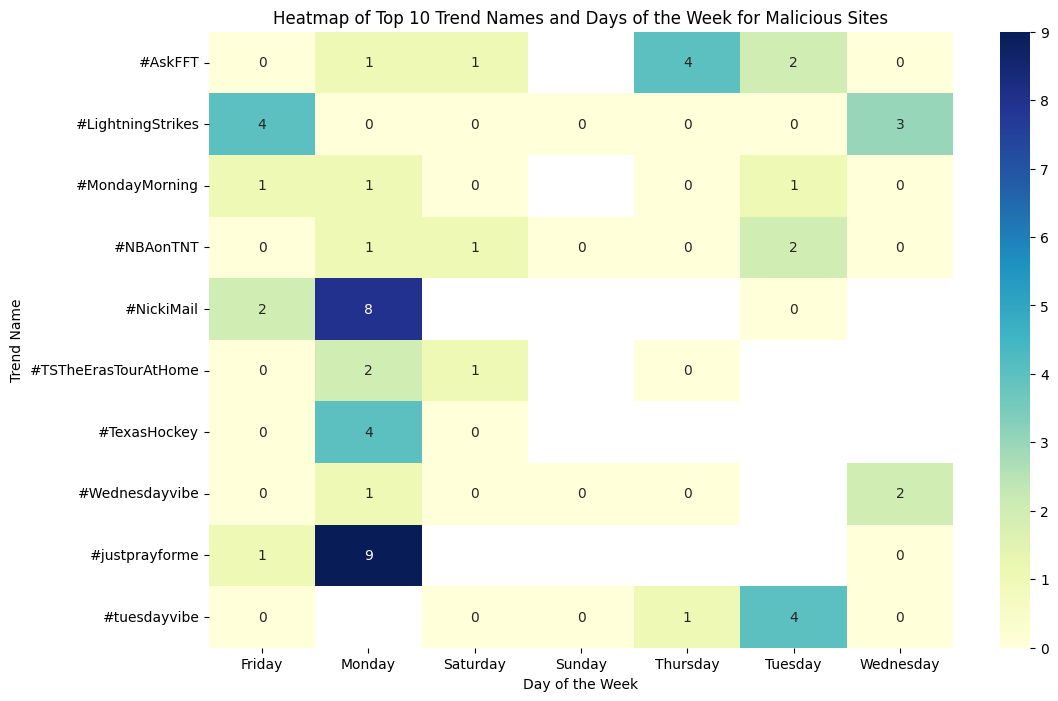

In [ ]:
# Create the DayOfWeek column
data_with_time['DayOfWeek'] = data_with_time['DiscoveryTime'].dt.day_name()
# Identify the top 10 trend names based on the sum of MaliciousIndicator
top_trends = data_with_time.groupby('TrendName')['MaliciousIndicator'].sum().nlargest(10).index

# Filter the data to include only the top 10 trend names
filtered_data = data_with_time[data_with_time['TrendName'].isin(top_trends)]

# Create a pivot table for the heatmap
pivot_table = pd.pivot_table(filtered_data, values='MaliciousIndicator',
                             index='TrendName', columns='DayOfWeek', aggfunc='sum')

# Plotting the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(pivot_table, annot=True, cmap='YlGnBu')
plt.title('Heatmap of Top 10 Trend Names and Days of the Week for Malicious Sites')
plt.xlabel('Day of the Week')
plt.ylabel('Trend Name')
plt.show()

Frequency of Trend Names in URLs

False    6923
True     2641
Name: TrendInURL, dtype: int64


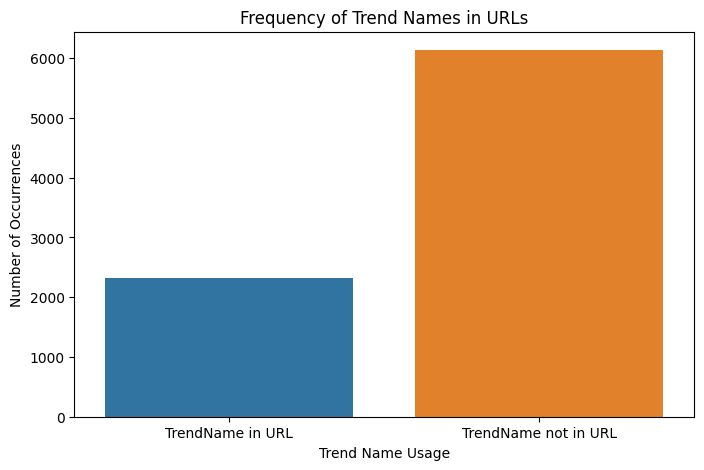

In [ ]:
# Standardize the strings (lowercase)
data['TrendName'] = data['TrendName'].str.lower()
data['TrendLink'] = data['TrendLink'].str.lower()

# Check if the trend name is in the URL
data['TrendInURL'] = data.apply(lambda row: row['TrendName'] in row['TrendLink'], axis=1)

# Aggregate the results
trend_in_url_summary = data['TrendInURL'].value_counts()

# Display the summary
print(trend_in_url_summary)

# trend_in_url_counts = data['TrendInURL'].value_counts()
trend_in_url_counts = {'TrendName in URL': 2320, 'TrendName not in URL': 6135}

# Create a bar chart
plt.figure(figsize=(8, 5))
sns.barplot(x=list(trend_in_url_counts.keys()), y=list(trend_in_url_counts.values()))

plt.title('Frequency of Trend Names in URLs')
plt.ylabel('Number of Occurrences')
plt.xlabel('Trend Name Usage')
plt.show()

Frequency Analysis of Specific Trend Name

<ipython-input-28-821caf1f9117>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  specific_trend_data['DiscoveryTime'] = pd.to_datetime(specific_trend_data['DiscoveryTime'])


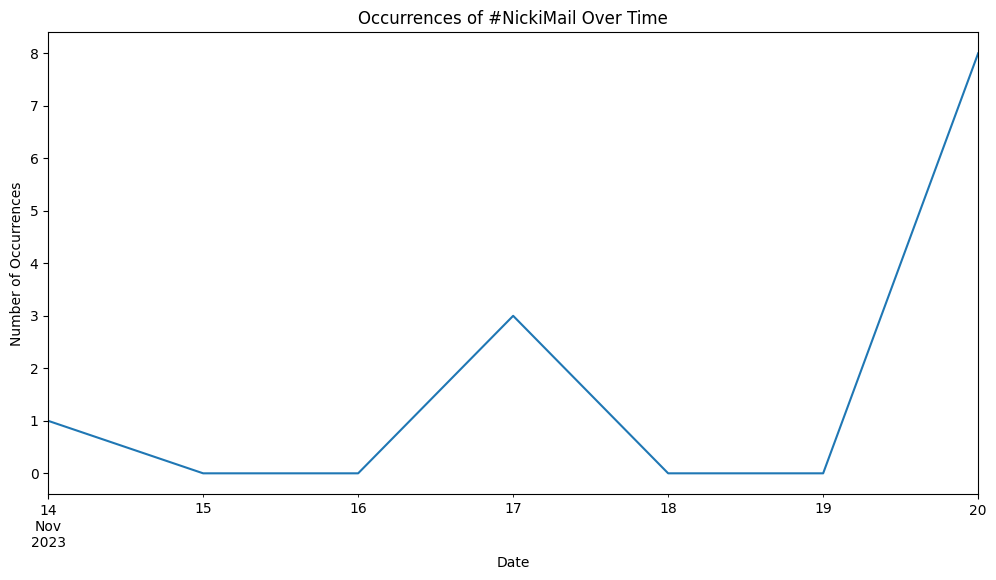

In [ ]:
# Filter data for a specific trend name
specific_trend_name = '#NickiMail'  # Replace with your specific trend name

specific_trend_data = data_with_time[data_with_time['TrendName'] == specific_trend_name]

# Check if 'DiscoveryTime' is in the columns, if so convert it to datetime and set as index
if 'DiscoveryTime' in specific_trend_data.columns:
    specific_trend_data['DiscoveryTime'] = pd.to_datetime(specific_trend_data['DiscoveryTime'])
    specific_trend_data.set_index('DiscoveryTime', inplace=True)

# Plotting - Resampling by day
plt.figure(figsize=(12, 6))
specific_trend_data.resample('D').size().plot()  # 'D' stands for daily resampling
plt.title(f'Occurrences of {specific_trend_name} Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Occurrences')
plt.show()